# Download Dataset

In [317]:
# !wget http://files.grouplens.org/datasets/movielens/ml-25m.zip
# !unzip ml-25m.zip
!ls ml-25m

README.txt        genome-tags.csv   movies.csv        tags.csv
genome-scores.csv links.csv         ratings.csv


# Necessary Imports

In [318]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import pandas as pd
import argparse


from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

Device:  cpu


# Hyper-Parameters

In [319]:
argument_parser = argparse.ArgumentParser()
argument_parser.add_argument("--epochs", dest = "EPOCHS", type = int, default = 5)
argument_parser.add_argument("--batch_size", dest = "BATCH_SIZE", type = int, default = 512)
argument_parser.add_argument("--embed_dim", dest = "EMBED_DIM", type = int, default = 10)
argument_parser.add_argument("--optimizer", dest = "OPTIMIZER", type = str, default = 'Adam')
argument_parser.add_argument("--loss_fn", dest = "LOSS_FN", type = str, default = 'MSELoss')
argument_parser.add_argument("--learning_rate", dest = "LEARNING_RATE", type = float, default =  1e-3)
arguments, unknown = argument_parser.parse_known_args()
print(arguments)

Namespace(EPOCHS=5, BATCH_SIZE=512, EMBED_DIM=10, OPTIMIZER='Adam', LOSS_FN='MSELoss', LEARNING_RATE=0.001)


# Ratings DataFrame in Triple Format ---> (user_id, movie_id, rating)

In [320]:
df = pd.read_csv('ml-25m/ratings.csv')

# Making UserId starts from 0 to N-1
df.userId = pd.Categorical(df.userId)
df['user_id'] = df.userId.cat.codes

# Making MovieId starts from 0 to N-1
df.movieId = pd.Categorical(df.movieId)
df['movie_id'] = df.movieId.cat.codes

# Standaridize (Centre) the Ratings
df['rating'] = df['rating'] - 2.5
df.drop(df.columns[[0, 1, 3]], 
        axis = 1, 
        inplace = True)
df.head(10)

,rating,user_id,movie_id
0,2.5,0,292
1,1.0,0,302
2,2.5,0,303
3,2.5,0,654
4,1.0,0,878
5,1.5,0,1061
6,1.0,0,1147
7,1.0,0,1186
8,2.5,0,1205
9,1.5,0,1217


# Movies DataFrame

In [321]:
movies_df = pd.read_csv('ml-25m/movies.csv')

# Making MovieId starts from 0 to N-1
movies_df.movieId = pd.Categorical(movies_df.movieId)
movies_df['movie_id'] = movies_df.movieId.cat.codes
movies_df.drop(movies_df.columns[[0, 2]], 
               axis = 1, 
               inplace = True)
movies_df.head(10)

,title,movie_id
0,Toy Story (1995),0
1,Jumanji (1995),1
2,Grumpier Old Men (1995),2
3,Waiting to Exhale (1995),3
4,Father of the Bride Part II (1995),4
5,Heat (1995),5
6,Sabrina (1995),6
7,Tom and Huck (1995),7
8,Sudden Death (1995),8
9,GoldenEye (1995),9


# Get no. of users and no. of movies

In [322]:
N = len(df['user_id'].unique())
M = len(df['movie_id'].unique())

print('Number of Users: ', N)
print('Number of Movies: ', M)

Number of Users:  162541
Number of Movies:  59047


# Splitting the Dataset into the Training set and Test set

In [323]:
train_data, test_data = train_test_split(df,
                                        random_state = 32, 
                                        test_size = 0.25, 
                                        shuffle = True)

print('Train Data Size: ', len(train_data))
print('Test Data Size: ', len(test_data))

Train Data Size:  18750071
Test Data Size:  6250024


# Dataset Class

In [324]:
class MovieRecommendationDataset(Dataset):
    def __init__(self, 
                 df: pd.DataFrame):
        self.u_ids = torch.from_numpy(df['user_id'].values).long()
        self.m_ids = torch.from_numpy(df['movie_id'].values).long()
        self.ratings = torch.from_numpy(df['rating'].values)
        
    def __len__(self):
        return len(self.u_ids)
    
    def __getitem__(self, 
                    idx: int):
        return self.u_ids[idx], self.m_ids[idx], self.ratings[idx]

# Dataset Objects for DataLoader

In [325]:
# Train Dataset Object
train_ds = MovieRecommendationDataset(train_data)
print(train_ds[0])

# Test Dataset Object
test_ds = MovieRecommendationDataset(test_data)
print(test_ds[0])

(tensor(5709), tensor(19832), tensor(1.5000, dtype=torch.float64))
(tensor(116264), tensor(1167), tensor(0.5000, dtype=torch.float64))


# Pytorch Data Loaders

In [326]:
# Train Data Loader
train_loader = DataLoader(train_ds, 
                          batch_size = arguments.BATCH_SIZE, 
                          shuffle = True)
# Test Data Loader
test_loader = DataLoader(test_ds, 
                        batch_size = arguments.BATCH_SIZE, 
                        shuffle = True)

# Model

In [327]:
class Model(nn.Module):
    def __init__(self, 
                 n_users, 
                 n_movies, 
                 embed_dim, 
                 n_hidden = 1024):
        super().__init__()
        self.U = n_users
        self.M = n_movies
        self.D = embed_dim
        self.H = n_hidden
        self.u_emb = nn.Embedding(self.U, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2 * self.D, self.H)
        self.fc2 = nn.Linear(self.H, 1)
        
    def forward(self, 
                u, 
                m):
        u = self.u_emb(u) # (Num_Samples, D)
        m = self.m_emb(m) # (Num_Samples, D)
        
        out = torch.cat((u, m), 1) # (Num_Samples, 2D)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [328]:
# Set Seed Value to make results reproducible
torch.manual_seed(32)

model = Model(N, 
              M, 
              arguments.EMBED_DIM)
model.to(device)

print('Model: ', model)

Model:  Model(
  (u_emb): Embedding(162541, 10)
  (m_emb): Embedding(59047, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)


In [329]:
# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    # Set model to train mode
    model.train()
    losses = []
    pbar = tqdm(loader, desc = 'Training Loop', colour = 'green')
    for users, movies, ratings in pbar:
        ratings = ratings.view(-1, 1).float()
        
        # Move Data to GPU
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
        
        # Zero the Parameter Gradients
        optimizer.zero_grad()
        
        # Calculate ratings_pred
        ratings_pred = model(users, movies)
        
        # Loss
        loss = loss_fn(ratings_pred, ratings)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()
        
    return round((sum(losses) / len(losses)), 4) # Return Average Loss

# Model Test Function
def test(loader, 
         model, 
         loss_fn):
    # Set model to eval mode
    model.eval()
    losses = []
    pbar = tqdm(loader, desc = 'Test Loop', colour = 'cyan')
    for users, movies, ratings in pbar:
        ratings = ratings.view(-1, 1).float()
        
        # Move Data to GPU
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
        
        # Calculate ratings_pred
        ratings_pred = model(users, movies)
    
        # Loss
        loss = loss_fn(ratings_pred, ratings)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
    
    return round((sum(losses) / len(losses)), 4) # Return Average Loss

# Model Training on Train dataset and Evaluation on Test dataset

In [330]:
# Optimizer
if arguments.OPTIMIZER == 'Adam':
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr = arguments.LEARNING_RATE)

# Loss Function
if arguments.LOSS_FN == 'MSELoss':
    loss_fn = nn.MSELoss().to(device)
    
# Path to Save Best Model
PATH = f'best-model.pt'

train_loss_list = []
test_loss_list = []

for epoch in range(arguments.EPOCHS):
    t0 = datetime.now()
    
    # Avg Training Loss
    train_loss = train(train_loader, 
                       model, 
                       optimizer, 
                       loss_fn)
    train_loss_list.append(train_loss)
    
    # Avg Val Loss
    test_loss = test(test_loader, 
                     model, 
                     loss_fn)
    test_loss_list.append(test_loss)
    
    dt = datetime.now() - t0
    
    print("Epoch {0}/{1} --> Train Loss: {2} | Val Loss: {3} | Duration: {4}".format(epoch + 1, arguments.EPOCHS, train_loss, test_loss, dt))
    
# Save model
torch.save(model.state_dict(), PATH)

Test Loop: 100%|██████████████| 12208/12208 [00:38<00:00, 313.77it/s, Loss=0.58]


Epoch 1/5 --> Train Loss: 0.8208 | Val Loss: 0.753 | Duration: 0:06:52.220749


Test Loop: 100%|█████████████| 12208/12208 [00:38<00:00, 315.77it/s, Loss=0.701]


Epoch 2/5 --> Train Loss: 0.7375 | Val Loss: 0.7299 | Duration: 0:06:51.963327


Test Loop: 100%|█████████████| 12208/12208 [00:40<00:00, 302.68it/s, Loss=0.671]


Epoch 3/5 --> Train Loss: 0.7123 | Val Loss: 0.7108 | Duration: 0:06:55.243908


Test Loop: 100%|█████████████| 12208/12208 [00:39<00:00, 308.67it/s, Loss=0.991]


Epoch 4/5 --> Train Loss: 0.698 | Val Loss: 0.7033 | Duration: 0:06:59.318624


Test Loop: 100%|█████████████| 12208/12208 [00:34<00:00, 354.71it/s, Loss=0.597]


Epoch 5/5 --> Train Loss: 0.6916 | Val Loss: 0.7 | Duration: 0:06:39.277676


# Line Plot Comparison: Train vs Test Loss

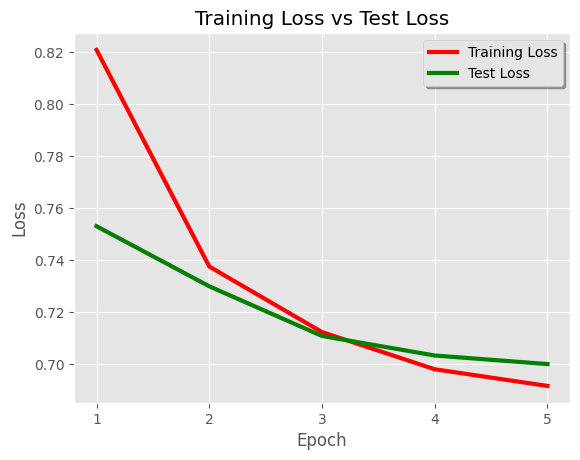

In [336]:
epochs = np.arange(arguments.EPOCHS) + 1

def plot_line(line_A_vals, 
              line_B_vals, 
              line_A_label, 
              line_B_label, 
              xlabel, 
              ylabel, 
              title):
    plt.style.use('ggplot')
    plt.plot(epochs, line_A_vals, label = line_A_label, color = "red", linewidth = '3', )
    plt.plot(epochs, line_B_vals, label = line_B_label, color = "green", linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(epochs)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    plt.show()
    
# Training vs Test Loss Plot
plot_line(train_loss_list, 
          test_loss_list, 
          'Training Loss', 
          'Test Loss', 
          'Epoch', 
          'Loss', 
          'Training Loss vs Test Loss')

# Load the saved model

In [332]:
saved_model = Model(N, 
                    M, 
                    arguments.EMBED_DIM).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

Model(
  (u_emb): Embedding(162541, 10)
  (m_emb): Embedding(59047, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

# Model Predict Function: Top 10 Recommendations for a User

In [340]:
def predict(user_id):
    # All Movie_ids watched by a User
    watched_m_ids = df[df['user_id'] == 1].movie_id.values
    
    # All Movie_ids not watched by a User
    potential_movie_ids = df[~df.movie_id.isin(watched_m_ids)].movie_id.unique()
    
    user_id_to_recommend = np.ones_like(potential_movie_ids) * user_id
    
    u_id_tensor = torch.from_numpy(user_id_to_recommend).long().to(device)
    potential_movie_ids_tensor = torch.from_numpy(potential_movie_ids).long().to(device)
    
    # Predicted Ratings for all Unseen Movies
    with torch.no_grad():
        predictions = saved_model(u_id_tensor, potential_movie_ids_tensor)
        
    predictions_np = predictions.cpu().numpy().flatten()
    
    # Sort Indices of Predictions in Descending Order
    sort_idx = np.argsort(-predictions_np)
    
    # Top 5 Recommendations
    print('```````````````````````````````````````')
    print('Top 5 Recommendations for User-{0}: '.format(user_id))
    print('```````````````````````````````````````')
    
    top_5_m_ids = potential_movie_ids[sort_idx[:5]]
    top_5_scores = predictions_np[sort_idx[:5]]
    
    for movie_id, score in zip(top_5_m_ids, top_5_scores):
        movie = movies_df[movies_df['movie_id'] == movie_id].title.values[0]
        print('Movie: {0}, Score: {1}'.format(movie, score))
    
# Top 5 Recommendations for first 10 Users
for user in range(0, 10):    
    predict(user)

```````````````````````````````````````
Top 5 Recommendations for User-0: 
```````````````````````````````````````
Movie: Two Lottery Tickets (2016), Score: 2.1235005855560303
Movie: Murder She Said (1961), Score: 2.102802276611328
Movie: Rue de l'Estrapade (1953), Score: 2.065976142883301
Movie: Hollywood Round-Up (1937), Score: 2.0595147609710693
Movie: Eisenstein in Guanajuato (2015), Score: 2.031919002532959
```````````````````````````````````````
Top 5 Recommendations for User-1: 
```````````````````````````````````````
Movie: Two Lottery Tickets (2016), Score: 2.249833822250366
Movie: Rue de l'Estrapade (1953), Score: 2.1372132301330566
Movie: Ave (2011), Score: 2.1085307598114014
Movie: Hollywood Round-Up (1937), Score: 2.094742774963379
Movie: Cabin in the Woods, The (2012), Score: 2.0097827911376953
```````````````````````````````````````
Top 5 Recommendations for User-2: 
```````````````````````````````````````
Movie: Rue de l'Estrapade (1953), Score: 2.1324121952056885
Movie